# Visualizing   Topographic Noise

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter

# Loading Dehm File to use as base

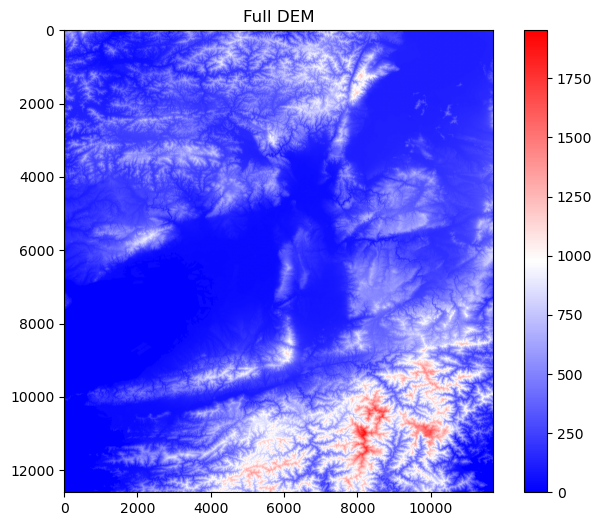

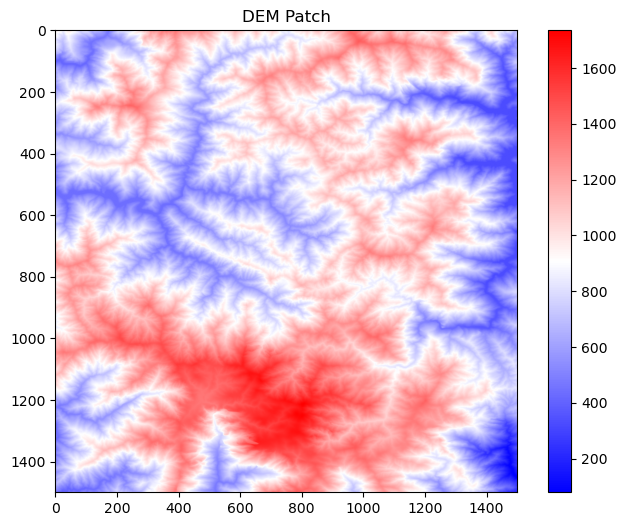

In [13]:
# Load a DEM file with big-endian float32 values.
def LoadDem(dem_path):
    data_type = np.dtype('>f4')
    raw_data = np.fromfile(dem_path, dtype=data_type)
    dem_data = raw_data.reshape((12602, 11702))
    return dem_data
full_dem = LoadDem('Kyoto-Osaka.dehm')

plt.figure(figsize=(8, 6))
plt.imshow(full_dem, cmap='bwr')
plt.colorbar()
plt.title('Full DEM')
plt.savefig('images/' + 'Full_DEM.png')

# Take a random patch of the DEM with size = size.
size = (1500, 1500)
max_y = full_dem.shape[0] - size[0]
max_x = full_dem.shape[1] - size[1]

start_y = random.randint(0, max_y)
start_x = random.randint(0, max_x)

dem_patch = full_dem[
    start_y : start_y + size[0],
    start_x : start_x + size[1]
]

def plot_patch(patch, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(patch, cmap='bwr')
    plt.colorbar()
    plt.title(title)
    plt.savefig('images/' + f'{title}.png')
    plt.show()

plot_patch(dem_patch, 'DEM Patch')

In [20]:
def GenerateDeltaH(dem_patch, std=5):
    """
    Processes a Digital Elevation Model (DEM) patch to calculate a delta_H map,
    and visualizes the intermediate steps in a single figure with multiple subplots.

    Args:
        dem_patch (np.ndarray): A 2D NumPy array representing the DEM patch.
        std (int, optional): The standard deviation to scale the final map. Defaults to 5.

    Returns:
        np.ndarray: The calculated delta_H map.
    """
    # --- 1. Data Processing ---
    # Apply Gaussian filter to smooth the DEM patch
    smoothed_dem = gaussian_filter(dem_patch, sigma=5)

    # Calculate roughness as the difference between the original and smoothed DEM
    roughness = dem_patch - smoothed_dem

    # Normalize the roughness to have zero mean and unit variance
    zero_mean_roughness = roughness - roughness.mean()
    roughness_std = zero_mean_roughness.std()

    if roughness_std > 1e-9:
        normalized_roughness = zero_mean_roughness / roughness_std
    else:
        normalized_roughness = zero_mean_roughness

    # Generate the delta_H map by scaling the normalized roughness
    delta_H_map = normalized_roughness * std

    # --- 2. Plotting ---
    # Store the processed images and their titles in lists
    images = [smoothed_dem, roughness, zero_mean_roughness, normalized_roughness, delta_H_map]
    titles = [
        'Smoothed (Gaussian Filter Applied)',
        'Roughness (DEM - Smoothed)',
        'Zero Mean Roughness',
        'Normalized Roughness',
        'Delta_H Map'
    ]

    # Create a figure and a set of subplots (1 row, 5 columns)
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    # Iterate through the subplots, images, and titles to create each plot
    for ax, img, title in zip(axes, images, titles):
        # Display the image on the current subplot axis
        im = ax.imshow(img, cmap='bwr')
        
        # Set the title for the subplot
        ax.set_title(title, fontsize=10)
        
        # Create a new colorbar for each subplot
        fig.colorbar(im, ax=ax, shrink=0.7)
        
        # Hide the ticks and labels on the x and y axes
        ax.set_xticks([])
        ax.set_yticks([])

    # Adjust the layout to prevent titles and colorbars from overlapping
    plt.tight_layout(pad=1.5)
    plt.savefig('images/Delta_H_Processing_Steps.png')
    plt.show()

    return delta_H_map

In [21]:
def LoadBaselines(baseline_type='Sentinel-1'):
    if baseline_type == 'Sentinel-1': 
        baselines_path = 'baselines_sentinel1.txt'
        col_to_use = 2
    elif baseline_type == 'PALSAR-2': 
        baselines_path = 'baselines_PALSAR-2.txt'
        col_to_use = 1
    df = pd.read_csv(baselines_path, delim_whitespace=True, header=None, usecols=[col_to_use])
    baselines_list = df.iloc[:, 0].values
    centered_baselines = baselines_list - np.mean(baselines_list)
    return centered_baselines.tolist()

baselines = LoadBaselines()

C:\Users\manav\AppData\Local\Temp\ipykernel_14724\2546184613.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(baselines_path, delim_whitespace=True, header=None, usecols=[col_to_use])


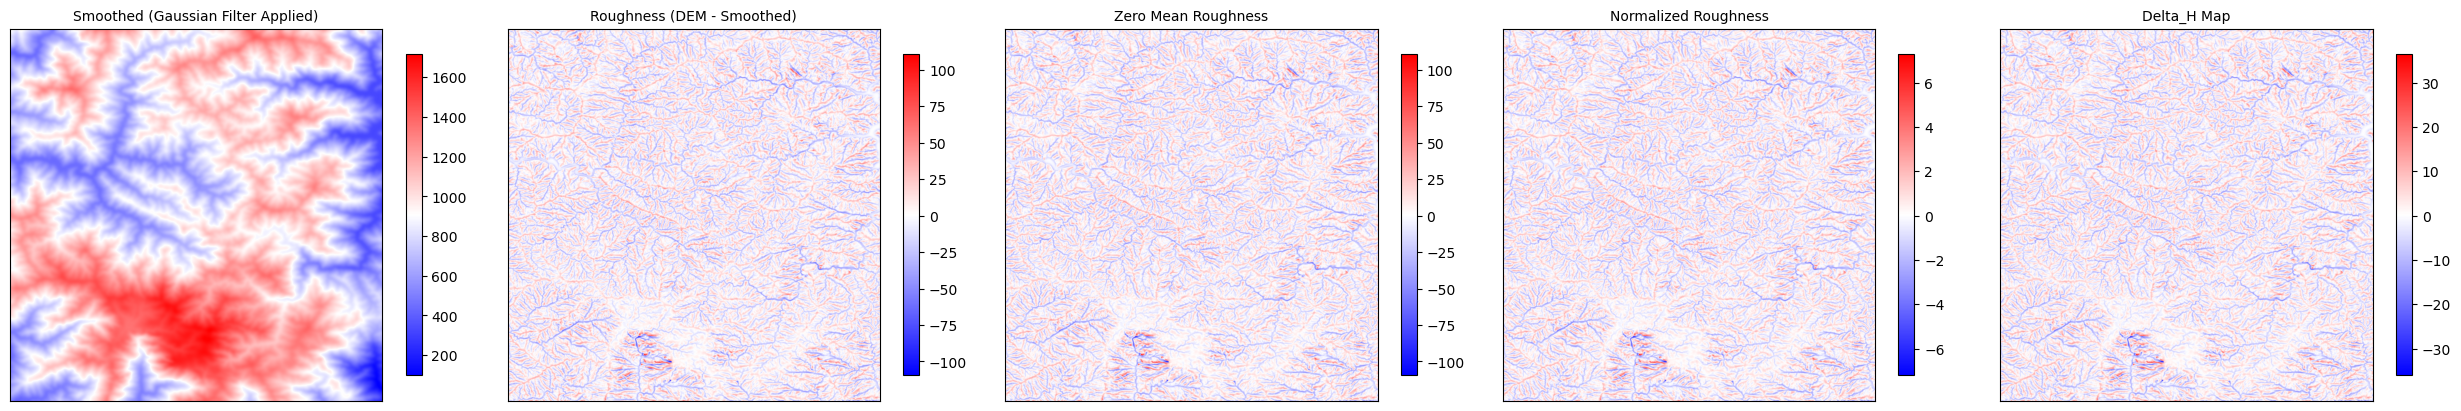

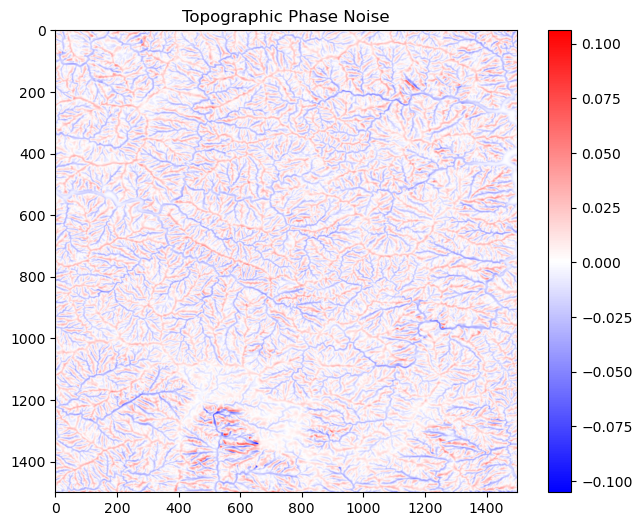

In [22]:
wavelength = 0.056  
SLANT_RANGE = 850000

def generate_topographic_noise(dem_patch):
    # Generate topographic phase noise based on the DEM patch
    delta_h_map = GenerateDeltaH(dem_patch, std=5.0)
    b_perp = np.random.choice(baselines)

    # Calculate the topographic phase noise
    incidence_angle_rad = np.deg2rad(40.0)
    numerator = -4 * np.pi * b_perp
    denominator = wavelength * SLANT_RANGE * np.sin(incidence_angle_rad)
    if abs(denominator) < 1e-9:
        return np.zeros(size)
    topo_phase_noise = (numerator / denominator) * delta_h_map
    return topo_phase_noise

plot_patch(generate_topographic_noise(dem_patch), 'Topographic Phase Noise')